# Ten simple rules for the computational modeling of behavioral data
#### Original Paper and Code (Matlab) by Robert C. Wilson and Anne GE Collins

> Python code and summaries by Neha Verma 

Example study used in implementation: <b> bandits task </b>
- Goal: to understand how people learn to maximize
their rewards in a case where the most rewarding choice is initially unknown
-  A participant makes a series of $T$ choices between $K$ options ('one armed bandits task')
- If played on trial $t$, each option $k$, pays out reward, $r_{t}$, which is 1 with reward probability $\mu_{t}^{k}$, and otherwise 0. The different reward probabilities of each option is initially unknown to the subject.
- As in the paper, we will assume that $T$ = 1000, $K$ = 2, and that the reward probabilities are $µ^{1}_{t} = 0.2$ for option 1 and $µ^{2}_{t} = 0.8$ for option 2.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def choose(p_choices):
    '''make choice according to choice probabilites'''
    r = np.random.rand()
    if r < p_choices[0]:
        return 0
    else:
        return 1


### A. Designing a Good Model

###### Approaches that are commonly used today
- Simplest approach: use heuristics to find a ‘reasonable’ way to handle information to produce the target behavior
- Scour the artificial intelligence, computer science, and applied mathematics literature for algorithms that have been used to solve similar problems for artificial agents.
    - Q-learning and temporal difference learning have been related to human and animal behavior and brain function
- Bayes-optimal perspective, to design algorithms that perform optimally given a model of the environment and the task.
    - used in ideal observer models in vision <br>

###### Model Rules:
1. A computational model should be as simple as possible, but no simpler
1. A computational model should be interpretable (as much as possible)
    - a negative learning rate is difficult to interpret in the framework of reinforcement learning
1. The models should capture all the hypotheses you plan to test
    - Competing models should have a genuine chance of relating to behavior in the task environment - and one should apply equal effort into fitting these models as with favored hypothesis

<ins>Model 1: Random responding</ins>
- Random behavior, maybe with slight bias for one option over other 
<br>
$p_{t}^{1}=b$ and $p_{t}^{2}=1-b$
<br>
- Just one free parameter controlling bias for option 1 over option 2, <br>
$\theta_{1} = b$

In [120]:
def random_response(T,𝜇, b):
    choices = np.zeros(T)
    rewards = np.zeros(T)
    for t in range(T):
        p_choices = [b, 1-b]
        choice = choose(p_choices)
        reward = int(np.random.rand() < 𝜇[choice])
        choices[t], rewards[t] = choice, reward
    return choices, rewards

<ins>Model 2:  Noisy win-stay-lose-shift</ins>
- Model applies win-stay-lose-shift rule with probability
$1 - \epsilon$, and chooses randomly with probability $\epsilon$
- Win-stay-lose-shift rule repeats rewarded actions and switches away from unrewarded actions
- $c_{t} = 1, 2$ is the choice at trial $t$, and $r_{t} = 0$, 1 the reward at trial $t$

$p_{t}^{2}= \begin{cases} 1-\epsilon/2 &\mbox{if} \; (c_{t-1}=k \; and r_{t-1}=1) \; OR \; (c_{t-1}\neq k \; and \; r_{t-1}=0) \\
\epsilon/2& \mbox{if}\;(c_{t-1}\neq k \; and r_{t-1}=1) \; OR \; (c_{t-1}= k \; and \; r_{t-1}=0) \end{cases}$

- One free parameter, the overall level of randomness: <br>
$\theta_{2} = \epsilon$

In [122]:
def wsls(T,𝜇,𝜖):
    choices, rewards = np.zeros(T), np.zeros(T)
    last_reward, last_choice = None, None
    for t in range(T):
        if last_reward is None:
            p_choices = [0.5, 0.5] #in first trial, choose randomly
        else:
            if last_reward == 1: #choice depends on last reward
                p_choices = np.multiply(𝜖/2,[1,1])
                p_choices[last_choice]=1-𝜖/2
            else:
                p_choices = np.multiply(1-𝜖/2,[1,1])
                p_choices[last_choice] = 𝜖/2
        choice = choose(p_choices) #make choice according to choice probabilities
        reward = int(np.random.rand() < 𝜇[choice]) #figure out reward
        last_reward, last_choice = reward, choice
        choices[t], rewards[t] = choice, reward
    return choices, rewards

<ins> Model 3:  Rescorla Wagner </ins>
- Learn the expected value of each option based on the history of previous outcomes and then use these values to make a decision about what to do next
- Simple model of learning: the value of option $k$,$Q^{k}_{t}$ is updated in response to reward $r_{t}$. $\alpha$ is the learning rate (value between 0 and 1) and describes the weight of the prediction error, $(r_{t}-Q^{k}_{t})$, updates the value of option k : <br>
$$Q^{k}_{t+1} = Q^{k}_{t}+\alpha(r_{t}-Q^{k}_{t})$$

- Assume $Q^{k}_{0}$ is 0
- Participants use the most valuable option the most frequently but occasionally explore and make mistakes
- <b>softmax</b> choice rule, choose option k with probability. $\beta$ is the inverse temperature parameter that controls the level of stochasticity in the choice (can range from 0 to $\infty$):<br>
$$p_{t}^{k}=\frac{exp(\beta Q^{k}_{t})}{ \sum _{i=1}^{K}exp(\beta Q^{i}_{t})}$$<br>
- Two free parameters: $\alpha$ (learning rate) and $\beta$ (inverse temperature) $$\theta_{3} = (\alpha, \beta)$$

In [123]:
def rescorlaWagner(T,𝜇,𝛼,𝛽):
    Q = [0.5, 0.5] #initialize
    choices, rewards = np.zeros(T), np.zeros(T)
    for t in range(T):
        p_choices = np.exp(𝛽*Q)/np.sum(np.exp(𝛽*Q)) #choice probability
        choice = choose(p_choices)
        reward = int(np.random.rand() < 𝜇[choice])
        Q[choice] = Q[choice] + (𝛼 *(reward - Q[choice])) #update the value of options
        choices[t], rewards[t] = choice, reward
    return choices, rewards

<ins> Model 4:  Choice Kernel </ins>
- This model captures the tendency for people to repeat their previous actions
- Assume that participants compute a choice kernet CK for each action, which keeps track of how frequently they have chosen that option in recent past.
$$CK^{k}_{t+1}=CK^{k}_{t}+\alpha_{c}(a^{k}_{t}-CK^{k}_{t})$$
-  $a^{k}_{t} = 1$ if option k is played on trial t, otherwise $a^{k}_{t} = 0$, and $\alpha$ is the choice-kernel learning rate. 
- Assume that choice kernel is always 0, but could be a parameter
- Each option chosen according to:
$$p^k_t= \frac{exp(\beta_{c} C K^k_{t})}{\sum_{i=1}^{K}exp(\beta_{c}CK^i_t)}$$
- Two free parameters $$\theta_{4}=(\alpha_{c}\beta{c})$$

In [5]:
def choiceKernel(T,𝜇,𝛼,𝛽):
    ck = np.zeros(2) #choice kernel
    choices, rewards = np.zeros(T), np.zeros(T)
    for t in range(T):
        p_choices = np.divide(np.exp(np.multiply(𝛽,ck)),np.sum(np.exp(np.multiply(𝛽,ck))))
        choice = choose(p_choices)
        reward = int(np.random.rand() < 𝜇[choice])
        ck = np.multiply((1-𝛼),ck)
        ck[choice] = ck[choice] + 𝛼*1 
        choices[t], rewards[t] = choice, reward
    return choices, rewards

<ins> Model 4:  Rescorla Wagner and Choice Kernel </ins>
- Rescorla Wagner and choice kernel values updated according to equations from above
$$p^k_t= \frac{exp(\beta_{c} C K^{k}_{t}+exp(\beta Q^{k}_{t})}{\sum_{i=1}^{K}exp(\beta_{c}Q^{i}_{t}+\beta_{c}CK^{i}_{t})}$$

- Four free parameters: $$\theta_{5}=(\alpha, \beta, \alpha_{c}, \beta_c)$$


In [6]:
def rwck(T,𝜇,𝛼,𝛽,𝛼C,𝛽C):
    Q = [0.5, 0.5]
    ck = np.zeros(2) #choice kernel
    choices, rewards = np.zeros(T), np.zeros(T)
    for t in range(T):
        p_choices = np.divide(np.exp(np.multiply(𝛽C,ck)\
                    +np.multiply(𝛽,Q)),np.sum(np.exp(np.multiply(𝛽C,ck)\
                    +np.multiply(𝛽,Q))))
        choice = choose(p_choices)
        reward = int(np.random.rand() < 𝜇[choice])
        ck = np.multiply((1-𝛼),ck)
        ck[choice] = ck[choice] + 𝛼*1 
        Q[choice] = Q[choice] + (𝛼 *(reward - Q[choice]))
        choices[t], rewards[t] = choice, reward
    return choices, rewards

### B. Simulate 
- In this step, we create fake, or surrogate data
- Clarify how the models and experimental design satisfy the goal of identifying a cognitive process in behavior
- Simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment

###### Simulation Rules

1. Define model-independent measures that capture key aspects of the processes you are trying to model.
1. Simulate the model across the range of parameter values
    - visualize behavior as a function of the parameters. Almost all models have free parameters. Understanding how changes to these parameters affect behavior will help you to better interpret your data and understand individual differences in fit parameters
1. Learning rate parameter, can relate to both speed of learning and noisiness in asymptotic behavior, as can the inverse temperature parameter
1. Visualize the simulated behavior of different models
    - can verify that behavior is qualitatively different for different models, making their predictions in the experimental setup different

###### Simulating behavior in the bandit task
- Experiment parameters should match the actual parameters used in the experiment

<ins>Parameters of the Task</ins>

In [125]:
T = 1000 #number of trials
n_choices = 2 #k = 2, number of options / bandits is 2
𝜇 = [0.2, 0.8] #reward probability of each option
n_reps = 100

- Sample these parameters randomly from prior distributions over each parameter, the exact form of which will vary from model to model

In [126]:
#Figure 2A
# Win-stay-lose-shift behavior varies widely between models.
choices_list = []
rewards_list = []

"Model 1: Random Responding"
choices_matrix = np.zeros((n_reps,T))
rewards_matrix = np.zeros((n_reps,T))
for i in range(n_reps):
    b = 0.5
    choices_matrix[i], rewards_matrix[i] = random_response(T,𝜇, b)
choices_list.append(choices_matrix)
rewards_list.append(rewards_matrix)
"Model 2: Win-stay-lose-shift"
choices_matrix = np.zeros((n_reps,T))
rewards_matrix = np.zeros((n_reps,T))
for i in range(n_reps):
    𝜖 = 0.05
    choices_matrix[i], rewards_matrix[i] = wsls(T,𝜇,𝜖)
choices_list.append(choices_matrix)
rewards_list.append(rewards_matrix)
"Model 3: Rescorla Wagner"
choices_matrix = np.zeros((n_reps,T))
rewards_matrix = np.zeros((n_reps,T))
for i in range(n_reps):
    𝛼, 𝛽 = 0.1, 5
    choices_matrix[i], rewards_matrix[i] = rescorlaWagner(T,𝜇,𝛼,𝛽)
choices_list.append(choices_matrix)
rewards_list.append(rewards_matrix)
"Model 4: Choice Kernel"
choices_matrix = np.zeros((n_reps,T))
rewards_matrix = np.zeros((n_reps,T))
for i in range(n_reps):
    𝛼, 𝛽 = 0.1, 3
    choices_matrix[i], rewards_matrix[i] = choiceKernel(T,𝜇,𝛼,𝛽)
choices_list.append(choices_matrix)
rewards_list.append(rewards_matrix)
"Model 5: Rescorla Wagner and Choice Kernel"
choices_matrix = np.zeros((n_reps,T))
rewards_matrix = np.zeros((n_reps,T))
for i in range(n_reps):
    𝛼, 𝛽  = 0.1, 5
    𝛼C,𝛽C = 0.1, 1
    choices_matrix[i], rewards_matrix[i] = rwck(T,𝜇,𝛼,𝛽,𝛼C,𝛽C)
choices_list.append(choices_matrix) 
rewards_list.append(rewards_matrix)

#choices list is a list of size 5, holding the choice matrices of each model
#the choice matrix has n_reps rows of the T choices of each simulation

In [118]:
#Analysis of wsls
def analysis_wsls(choices_list, rewards_list):
    curr, prev = 1, 0
    winStay, loseStay = 0, 0
    while curr < T:
        l_choice = choices_list[prev]
        stay =  int(l_choice == choices_list[curr])
        l_reward = rewards_list[prev]
        winStay += int(l_reward != 0)*stay
        loseStay += int(l_reward == 0)*stay
        curr+=1
        prev+=1       
    return winStay/np.sum(rewards_list), loseStay/(T - np.sum(rewards_list))
    
stay_results = []
for i in range(5):
    w_total, l_total = 0, 0
    for j in range(n_reps):
        w,l = analysis_wsls(choices_list[i][j], rewards_list[i][j])
        w_total += w
        l_total += l
    w_avg, l_avg = w_total/n_reps, l_total/n_reps
    stay_results.append((w_avg, l_avg))
        
        

(0.0, 1.0)

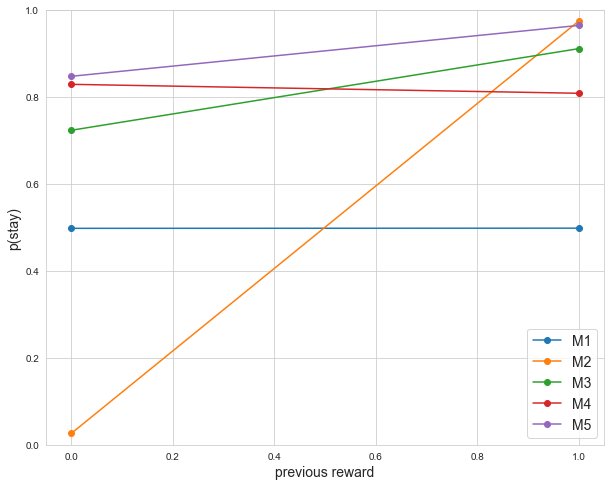

In [128]:
plt.figure(figsize=(10,8))
for i in range(5):
    plt.plot([0,1],list(stay_results[i])[::-1],marker="o",label="M"+str(i+1))
plt.legend(prop={"size":14})
plt.xlabel("previous reward", size = 14)
plt.ylabel("p(stay)", size=14)
plt.ylim(0, 1)

- To visualize the simulated results we look at two model independent measures: the probability of repeating an action, referred to as p(stay) in the paper, and the probability of choosing the correct option, referred to as p(correct).

    - Figure above plots p(stay) as a function of the reward on the last trial for each of the models with a particular set of parameters.

    - For some models (in particular the win-stay-lose-shift model, Model 2) we expect a strong dependence on past reward, but for others (such as the random responder, Model 1) we expect no dependence.
- In addition, the similarity to the graph in the original paper validates that my implementations of these models are correct.

### C. Reflection and Next Steps

My scope for this project was to read, understand, and implement the 5 models (I originally thought there were 10) that this paper covered. Implementing the functions allowed me to learn in depth the way that the five models work, but also gave me a deeper understanding of the bandit task. I also understand how the task and models relate  to behavioral data (noted above). 

My plan (for the next week) is to also try and implement parameter fitting that this paper describes. I plan on doing this by first understanding, implementing and plotting the multiple local minima and then plotting the parameter recovery. Finally, I hope to also implement a model that has a side bias, B in addition to choosing based on the learning value.

It has been really interesting to read about and understand behavioral data. After parameter fitting, I hope to post this on my github, and explore if there are additional models that I can add to this list of 5 models (maybe get context on updates in methodology as well as updates on this paper from Professor Anne Collins, as it has been two years since this paper was released). In addition, I hope to study Anne Gradial's research on modeling the basal ganglia and hopefully also explore computational modeling of the frontal lobe.